# **The Vehicle Type Classification Project**



# Summary


- **Use Case:** Vehicle Type
- **Algorithm:** MobileNetV2
- **Number of training images:** 603
- **Number of classes:** 7
- **Batch Size:** 64
- **Optimizer:** Adam 
- **Learning Rate:** 0.0001
- **Loss Type:**CategoricalCrossentropy
- **Transfer Learning:** Yes | Imagenet



 ## Labels
 
 0: 'car-bus-alltypes',

 1: 'car-sedan-alltypes',
 
 2: 'car-suv-alltypes',
 
 3: 'motocycle-bicycle-kids',
 
 4: 'motocycle-bicycle-racing',
 
 5: 'motocycle-motorbike-chopper',
 
 6: 'motocycle-motorbike-sport'

## Import Library

In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, BatchNormalization
#from tensorflow.keras.applications import ResNet50
#from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import sys
import tensorflow as tf
import h5py
import numpy as np
import sys

In [ ]:
print(tf.__version__)

2.4.1


## 구글드라이브 마운트 하기

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/day19')

### 다음 데이터셋을 다운로드하여, 압축을 풀고, 구글 드라이브에 올려놓는다.

https://drive.google.com/file/d/1oAW1QoG77-WLPkPa2tAM4Mnpt1cznnDl/view?usp=sharing


In [4]:
!unzip 38_실습파일.zip

Archive:  38_실습파일.zip
   creating: test-images/
  inflating: __MACOSX/._test-images  
  inflating: test-images/bicycle.png  
  inflating: __MACOSX/test-images/._bicycle.png  
  inflating: test-images/bus.jpg     
  inflating: __MACOSX/test-images/._bus.jpg  
   creating: trained-models/
  inflating: __MACOSX/._trained-models  
   creating: trained-models/mobilenetv2/
  inflating: __MACOSX/trained-models/._mobilenetv2  
  inflating: trained-models/mobilenetv2/vehicle-classification-by-type-mobilenetv2-anis-1.h5  
  inflating: __MACOSX/trained-models/mobilenetv2/._vehicle-classification-by-type-mobilenetv2-anis-1.h5  
  inflating: trained-models/mobilenetv2/vehicle-classification-by-type-mobilenetv2-anis-1-2.h5  
  inflating: __MACOSX/trained-models/mobilenetv2/._vehicle-classification-by-type-mobilenetv2-anis-1-2.h5  
  inflating: trained-models/mobilenetv2/vehicle-classification-by-type-mobilenetv2-anis-2.h5  
  inflating: __MACOSX/trained-models/mobilenetv2/._vehicle-classifica

## 경로 셋팅

In [5]:
TYPE='type'
model_type='mobilenetv2'
user='block'
iteration='1-2'

first_time_training=True

PROJECT_PATH= '/content/drive/MyDrive/Colab Notebooks/day19'

HDF5_DATASET_PATH=PROJECT_PATH+'/vehicle_datasets/vehicle-type-dataset-SIZE224-train-dev-test-v2.hdf5'

TARGET_CLASSIFICATION_MODEL=PROJECT_PATH+'/trained-models/'+model_type+'/'+'vehicle-classification-by-'+TYPE+'-'+model_type+'-'+user+'-'+iteration+'.h5'

CHECKPOINT_PATH = PROJECT_PATH+'/checkpoints/'+model_type+'/'+'by-'+TYPE+'-'+model_type+'-'+user+'-'+iteration+'.h5'

LOGFILE_PATH=PROJECT_PATH+'/log/'+model_type+'/'+model_type+'-by-'+TYPE+'-training-log'+user+'-'+iteration+'.csv'


In [6]:
print('PROJECT_PATH: ',PROJECT_PATH)
print('HDF5_DATASET_PATH: ', HDF5_DATASET_PATH)
print('TARGET_CLASSIFICATION_MODEL: ',TARGET_CLASSIFICATION_MODEL)
print('CHECKPOINT_PATH: ',CHECKPOINT_PATH)
print('LOGFILE_PATH: ',LOGFILE_PATH)

PROJECT_PATH:  /content/drive/MyDrive/Colab Notebooks/day19
HDF5_DATASET_PATH:  /content/drive/MyDrive/Colab Notebooks/day19/vehicle_datasets/vehicle-type-dataset-SIZE224-train-dev-test-v2.hdf5
TARGET_CLASSIFICATION_MODEL:  /content/drive/MyDrive/Colab Notebooks/day19/trained-models/mobilenetv2/vehicle-classification-by-type-mobilenetv2-block-1-2.h5
CHECKPOINT_PATH:  /content/drive/MyDrive/Colab Notebooks/day19/checkpoints/mobilenetv2/by-type-mobilenetv2-block-1-2.h5
LOGFILE_PATH:  /content/drive/MyDrive/Colab Notebooks/day19/log/mobilenetv2/mobilenetv2-by-type-training-logblock-1-2.csv


In [7]:

sys.path.append(PROJECT_PATH)


# **Load the Dataset**

In [14]:
hf = h5py.File(HDF5_DATASET_PATH, 'r')

np.array( hf['trainY'] )

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [15]:
def load_dataset_from_hdf5_file(hdf_file_path):
  # 함수 만들기
  hf = h5py.File(hdf_file_path , 'r')

  X_train = np.array( hf['trainX']  )
  y_train = np.array( hf['trainY'] )
  train_label = np.array( hf['trainLabels'])

  X_test = np.array( hf['testX'])
  y_test = np.array( hf['testY'])
  test_label = np.array( hf['testLabels'])

  X_val = np.array( hf['devX'])
  y_val = np.array( hf['devY'])
  val_label = np.array( hf['devLabels'])

  return X_train, y_train, train_label, X_test, y_test, test_label, X_val, y_val, val_label
  

In [16]:
X_train, y_train, train_label, X_test, y_test, test_label, X_val, y_val, val_label=load_dataset_from_hdf5_file(HDF5_DATASET_PATH)

In [19]:
train_label

array([b'motocycle-motorbike-chopper', b'motocycle-motorbike-chopper',
       b'motocycle-bicycle-racing', b'car-suv-alltypes',
       b'motocycle-motorbike-sport', b'motocycle-bicycle-racing',
       b'car-suv-alltypes', b'car-suv-alltypes', b'car-bus-alltypes',
       b'car-bus-alltypes', b'car-bus-alltypes', b'car-bus-alltypes',
       b'motocycle-motorbike-chopper', b'motocycle-bicycle-kids',
       b'motocycle-bicycle-kids', b'motocycle-bicycle-kids',
       b'motocycle-bicycle-kids', b'motocycle-motorbike-chopper',
       b'motocycle-bicycle-racing', b'motocycle-motorbike-chopper',
       b'motocycle-motorbike-chopper', b'car-suv-alltypes',
       b'motocycle-motorbike-sport', b'motocycle-motorbike-sport',
       b'car-bus-alltypes', b'car-sedan-alltypes',
       b'motocycle-bicycle-kids', b'motocycle-motorbike-sport',
       b'motocycle-motorbike-chopper', b'car-suv-alltypes',
       b'motocycle-bicycle-kids', b'car-suv-alltypes',
       b'car-bus-alltypes', b'motocycle-motorbik

# 사진이미지 확인해 보기

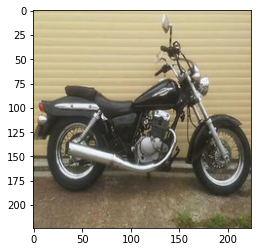

In [29]:
plt.imshow( X_train[1] )
plt.show()

In [30]:
X_train[1].shape

(224, 224, 3)

In [31]:
X_train[1].max()

1.0

In [32]:
X_train[1].min()

0.00784313725490196

In [33]:
y_train[1]

array([0, 0, 0, 0, 0, 1, 0])

In [34]:
y_train[1].argmax()

5

In [35]:
train_label[1]

b'motocycle-motorbike-chopper'

# 모델링하기 : 트랜스퍼 러닝 적용

# Data Augmentation

In [36]:
trainGen = ImageDataGenerator(rotation_range=20,
                              horizontal_flip = True)

In [56]:
baseModel = MobileNetV2(weights='imagenet', include_top=False,
                        input_shape=(224, 224, 3))

In [57]:
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [58]:
headModel = baseModel.output

In [59]:
headModel = AveragePooling2D((4,4))(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation='relu')(headModel)
headModel = BatchNormalization()(headModel)
headModel = Dense(64, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = BatchNormalization()(headModel)
headModel = Dense(7, activation='softmax')(headModel)

In [60]:
baseModel.trainable = False

In [61]:
model = Model(inputs = baseModel.input, outputs = headModel)

###  콜백 만들기 : 가장 좋은 모델을 자동 저장하도록 함. 로그도 저장하도록 함.

In [62]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
import pickle

In [63]:
cp = ModelCheckpoint(filepath=CHECKPOINT_PATH, monitor='val_accuracy',
                     save_best_only = True, verbose = 1)

In [64]:
csv_logger = CSVLogger(filename=LOGFILE_PATH, append = True)

## 컴파일과 학습 : 에포크는 50

In [65]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', 
              metrics = 'accuracy')

In [66]:
CHECKPOINT_PATH

'/content/drive/MyDrive/Colab Notebooks/day19/checkpoints/mobilenetv2/by-type-mobilenetv2-block-1-2.h5'

In [67]:
LOGFILE_PATH

'/content/drive/MyDrive/Colab Notebooks/day19/log/mobilenetv2/mobilenetv2-by-type-training-logblock-1-2.csv'

In [68]:
if not os.path.exists(PROJECT_PATH+'/checkpoints/'+model_type+'/') :
  os.makedirs(PROJECT_PATH+'/checkpoints/'+model_type+'/')

if not os.path.exists(PROJECT_PATH+'/log/'+model_type+'/') :
  os.makedirs(PROJECT_PATH+'/log/'+model_type+'/')

In [69]:
history = model.fit(trainGen.flow(X_train, y_train, batch_size=64),
                    # 만개의 데이터를 5천개씩 학습하면, steps_per_epoch는 2가 된다.
                    # 만개의 데이터를 1개씩 학습하면, steps_per_epoch는 10000이 된다.
                    steps_per_epoch = len(X_train) // 64,
                    validation_data = (X_val, y_val),
                    validation_steps = len(X_val) // 64,
                    callbacks = [cp, csv_logger],
                    epochs = 50
)

Epoch 1/50
9/9 [==============================] - 8s 619ms/step - loss: 2.6394 - accuracy: 0.1346 - val_loss: 2.0258 - val_accuracy: 0.1733

Epoch 00001: val_accuracy improved from -inf to 0.17333, saving model to /content/drive/MyDrive/Colab Notebooks/day19/checkpoints/mobilenetv2/by-type-mobilenetv2-block-1-2.h5
Epoch 2/50
9/9 [==============================] - 5s 520ms/step - loss: 2.2973 - accuracy: 0.2005 - val_loss: 1.7421 - val_accuracy: 0.2667

Epoch 00002: val_accuracy improved from 0.17333 to 0.26667, saving model to /content/drive/MyDrive/Colab Notebooks/day19/checkpoints/mobilenetv2/by-type-mobilenetv2-block-1-2.h5
Epoch 3/50
9/9 [==============================] - 5s 532ms/step - loss: 1.9308 - accuracy: 0.3155 - val_loss: 1.5018 - val_accuracy: 0.4000

Epoch 00003: val_accuracy improved from 0.26667 to 0.40000, saving model to /content/drive/MyDrive/Colab Notebooks/day19/checkpoints/mobilenetv2/by-type-mobilenetv2-block-1-2.h5
Epoch 4/50
9/9 [==============================

# 트레이닝 및 밸리데이션의 정확도와 로스를 차트로 보기

# 모델 평가